In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

/Users/hemalathaningappakondakundi/anaconda3/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
df = pd.read_csv('Traffic_Crashes_-_Crashes_20231030.csv')
df = df.drop(['CRASH_DATE_EST_I','LANE_CNT','REPORT_TYPE','INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I','PHOTOS_TAKEN_I',
              'STATEMENTS_TAKEN_I', 'DOORING_I','WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I'], axis = 1)
df = df.dropna()
#Convert Time Columns to Date Time Format
df['DATE_POLICE_NOTIFIED'] = pd.to_datetime(df['DATE_POLICE_NOTIFIED'])
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])
df.drop_duplicates(subset='CRASH_RECORD_ID', inplace=True)
# changing the column name to match with gpd geometry file to merge later
df = df.rename(columns={'BEAT_OF_OCCURRENCE' : 'beat_num'})
# head of the data
df.head()


,CRASH_RECORD_ID,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,JG361138,2023-07-29 14:45:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,1.0,0.0,14,7,7,41.854120,-87.665902,POINT (-87.665902342962 41.854120262952)
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,JG388133,2023-08-18 17:58:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,...,1.0,0.0,1.0,0.0,17,6,8,41.942976,-87.761883,POINT (-87.761883496974 41.942975745006)
13,fd05285e9d273fe20cbbebf84794045828a2ba589073b6...,JG367631,2023-07-29 14:30:00,10,NO CONTROLS,NO CONTROLS,UNKNOWN,UNKNOWN,ANGLE,PARKING LOT,...,0.0,0.0,2.0,0.0,14,7,7,41.809781,-87.594213,POINT (-87.594212812011 41.809781151018)
14,fda2491d33ac819033f4aaa7ed901120f2f6785b7e5bbb...,JG361228,2023-07-29 00:50:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DARKNESS,SIDESWIPE OPPOSITE DIRECTION,NOT DIVIDED,...,0.0,0.0,2.0,0.0,0,7,7,41.899225,-87.696642,POINT (-87.696642374961 41.899224596015)
20,161ff459c7fff8e1359204d1c54db502674fdfbf7036a9...,JG432000,2023-09-20 12:57:00,15,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,...,0.0,0.0,2.0,0.0,12,4,9,41.744152,-87.585945,POINT (-87.585945066953 41.744151639042)


In [3]:
df['beat_num']=df['beat_num'].astype(int)
# List of numerical columns
numerical_columns = ['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'INJURIES_TOTAL','INJURIES_FATAL','INJURIES_FATAL','INJURIES_INCAPACITATING','INJURIES_NON_INCAPACITATING',
                     'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'LATITUDE', 'LONGITUDE']

# Computeing statistics for each numerical column
numerical_stats = df[numerical_columns].describe().transpose()

df['YEAR'] = df['CRASH_DATE'].dt.year
df['MONTH'] = df['CRASH_DATE'].dt.month
df['DAY'] = df['CRASH_DATE'].dt.day
df['posted_speed'] = pd.cut(x=df['POSTED_SPEED_LIMIT'], bins = [0,15,25,40,75],
                         labels = ['0-15', '16-25',
                                    '26-40', '41+'])


In [4]:
df['INJURIES_CHECK'] = df[['INJURIES_FATAL', 'INJURIES_INCAPACITATING',
                           'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT']].sum(axis=1)

# Ensure this column matches the 'INJURIES_TOTAL' column
mismatches = df[df['INJURIES_CHECK'] != df['INJURIES_TOTAL']]
if mismatches.empty:
    print("All injury totals are accurate!")
else:
    print("There are mismatches in injury totals.")

All injury totals are accurate!


In [5]:
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df['CRASH_TIME_OF_DAY'] = pd.cut(df['CRASH_HOUR'], bins=bins, labels=labels, right=False)
# Create a 'week' column based on the 'CRASH_DAY_OF_WEEK' values
df['week'] = df['CRASH_DAY_OF_WEEK'].apply(lambda x: 'Weekend' if x in [1, 7] else 'Weekday')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['POSTED_SPEED_LIMIT_scaled'] = scaler.fit_transform(df[['POSTED_SPEED_LIMIT']])

In [6]:
from vega import VegaLite

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
temp = df
# Set CRASH_DATE as the index
temp.set_index('CRASH_DATE', inplace=True)
# Resample the data by day and count the number of crashes per day
crashes_per_day = temp.resample('D').size()
graph_1=pd.DataFrame(crashes_per_day)
graph_1 = pd.DataFrame({'CRASH_DATE': crashes_per_day.index,
                   'CRASH_NUM':  crashes_per_day.values})
graph_1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3879 entries, 0 to 3878
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CRASH_DATE  3879 non-null   datetime64[ns]
 1   CRASH_NUM   3879 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 60.7 KB


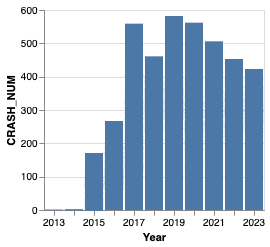

In [8]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
 "mark": "bar",
  "encoding": {     
"x": {
      "timeUnit": "year",
      "field": "CRASH_DATE",
      "type": "ordinal",
      "title": "Year"
    },
    "y": {"field": "CRASH_NUM", "type": "quantitative"}
  }
}, graph_1)

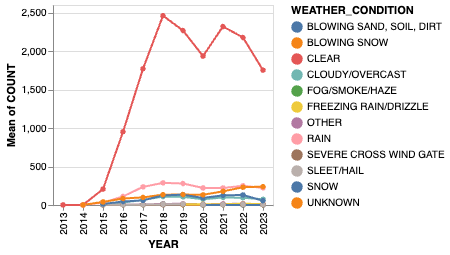

In [9]:
temp = df
grouped_data = temp.groupby(['YEAR','WEATHER_CONDITION', 'PRIM_CONTRIBUTORY_CAUSE']).size().reset_index(name='COUNT')

VegaLite(
{
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "mark": {
    "type": "line",
    "point": bool(1)
  },
  "encoding": {
    "x": {"type": "nominal", "field": "YEAR"},
    "y": {"aggregate":"mean", "field": "COUNT", "type": "quantitative"},
    "color": {"field": "WEATHER_CONDITION", "type": "nominal"}
  }
},grouped_data)

In [10]:
import altair as alt
grouped_data13 = df.groupby(["DAMAGE","YEAR"]).size().reset_index(name='INJURIES_TOTAL')

source = grouped_data13

alt.Chart(source).mark_area(opacity=0.3).encode(
    x="YEAR:N",
    y=alt.Y("INJURIES_TOTAL:Q").stack(None),
    color="DAMAGE:N"
)

alt.Chart(...)

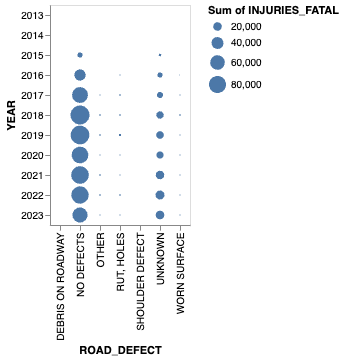

In [11]:
grouped_data7= df.groupby(['ROAD_DEFECT','DEVICE_CONDITION','YEAR']).size().reset_index(name='INJURIES_FATAL')
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "mark": "circle",
  "encoding": {
    "y": {
      "field": "YEAR",
      "type": "nominal",
    },
    "x": {
      "field": "ROAD_DEFECT",
      "type": "nominal",
    },
    "size": {
      "field": "INJURIES_FATAL",
      "type": "quantitative",
        "aggregate": "sum"
    }
  }
},grouped_data7)

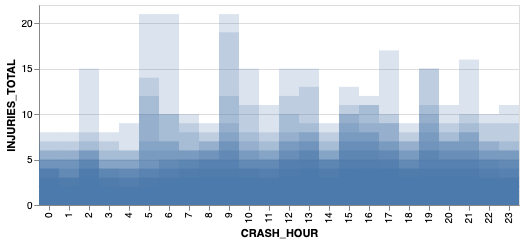

In [12]:
grouped_data5=df.groupby(['CRASH_HOUR','INJURIES_TOTAL','WEATHER_CONDITION']).size().reset_index(name='COUNT')

VegaLite(
    {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "mark": "rect",
  "encoding": {
    "opacity": {
      "condition": {
        "test": "test(regexp(search_input,'i'),datum.WEATHER_CONDITION)",
        "value": 0.2
      },
      "value": 0.1
    },
    "tooltip": {"field": "WEATHER_CONDITION", "type": "nominal"},
    "y": {"field": "INJURIES_TOTAL", "type": "quantitative"},
    "x": {"field": "CRASH_HOUR", "type": "nominal"}
  },
  "params": [
    {
      "name": "search_input",
      "bind": {
        "input": "search",
        "placeholder": "WEATHER_CONDITION",
        "name": "Search"
      },
      "value": ""
    }
  ]
},grouped_data5)

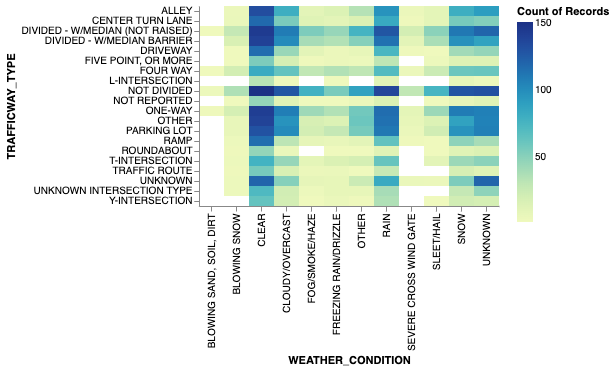

In [13]:
grouped_data6=df.groupby(['FIRST_CRASH_TYPE','TRAFFICWAY_TYPE','YEAR','WEATHER_CONDITION']).size().reset_index(name='INJURIES_TOTAL')
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "data": {"url": "data/movies.json"},
  "transform": [{
    "filter": {"and": [
      {"field": "WEATHER_CONDITIONg", "valid": bool(0)},
      {"field": "TRAFFICWAY_TYPE", "valid": bool(0)}
    ]}
  }],
  "mark": "rect",
  "width": 300,
  "height": 200,
  "encoding": {
    "x": {
#       "bin": {"maxbins":60},
      "field": "WEATHER_CONDITION",
      "type": "nominal"
    },
    "y": {
#       "bin": {"maxbins": 40},
      "field": "TRAFFICWAY_TYPE",
      "type": "nominal"
    },
    "color": {
      "aggregate": "count",
      "type": "quantitative"
    }
  },
  "config": {
    "view": {
      "stroke": "transparent"
    }
  }
},grouped_data6)

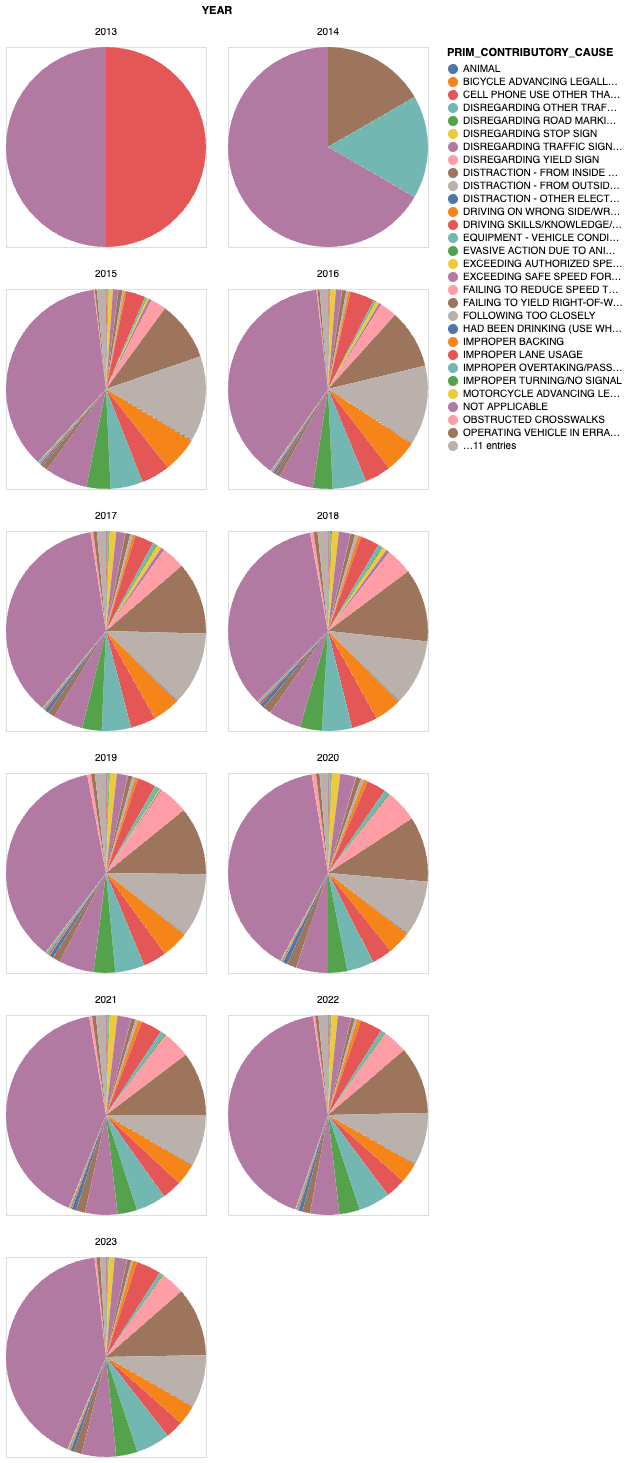

In [14]:
grouped_data8 = df.groupby(['YEAR', 'PRIM_CONTRIBUTORY_CAUSE']).size().reset_index(name='COUNT')

VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "name": "trellis_barley", 
 "mark": {"type": "arc", "tooltip": bool(1)},
  "encoding": {
    "facet": {
      "field": "YEAR",
      "type": "ordinal",
      "columns": 2,
      "sort": {"op": "median", "field": "YEAR"},
    },
    "theta": {"field": "COUNT", "type": "quantitative", "stack": "normalize"},
    "color": {"field": "PRIM_CONTRIBUTORY_CAUSE", "type": "nominal"}
  
  }
},grouped_data8)

In [15]:
grouped_data10 = df.groupby(["YEAR","WEATHER_CONDITION","INJURIES_INCAPACITATING","INJURIES_NON_INCAPACITATING","INJURIES_FATAL","INJURIES_REPORTED_NOT_EVIDENT","INJURIES_UNKNOWN","INJURIES_TOTAL"]).size().reset_index(name='COUNT')


source = grouped_data10

pts = alt.selection_point(encodings=['x'])

rect = alt.Chart(source).mark_rect().encode(
    alt.X('YEAR:N'),
    alt.Y('INJURIES_TOTAL:Q'),
    alt.Color('count()').scale(scheme='greenblue').title('Total Records')
)

circ = rect.mark_point().encode(
    alt.ColorValue('grey'),
    alt.Size('count()').title('Records in Selection')
).transform_filter(
    pts
)

bar = alt.Chart(source, width=550, height=200).mark_bar().encode(
    x='WEATHER_CONDITION:N',
    y='count()',
    color=alt.condition(pts, alt.ColorValue("steelblue"), alt.ColorValue("grey"))
).add_params(pts)

alt.vconcat(
    rect + circ,
    bar
).resolve_legend(
    color="independent",
    size="independent"
)

alt.VConcatChart(...)

In [16]:

grouped_data11 = df.groupby(["DEVICE_CONDITION","CRASH_HOUR","CRASH_DAY_OF_WEEK"]).size().reset_index(name='INJURIES_TOTAL')
# generate fake data
source = grouped_data11

selector = alt.selection_point(fields=['DEVICE_CONDITION'])

# color_scale = alt.Scale(domain=['M', 'F'],
#                         range=['#1FC3AA', '#8624F5'])

base = alt.Chart(source).properties(
    width=250,
    height=250
).add_params(selector)



points = base.mark_bar(filled=True, size=20).encode(
#       x='CRASH_HOUR:Q',
#     y='CRASH_DAY_OF_WEEK:Q',
    x=alt.X('mean(CRASH_HOUR):Q'),
    y=alt.Y('CRASH_DAY_OF_WEEK:Q').scale(domain=[0,7]),
    color=alt.condition(
        selector,
        'DEVICE_CONDITION:N',
        alt.value('lightgray')),
)

hists = base.mark_bar(opacity=1, thickness=100).encode(
    x=alt.X('INJURIES_TOTAL')
        .bin(step=5), # step keeps bin size the same
        
    y=alt.Y('count()')
        .stack(None),
    color=alt.Color('DEVICE_CONDITION:N')
).transform_filter(
    selector
)

points | hists

alt.HConcatChart(...)

In [17]:
grouped_data12 = df.groupby(["DEVICE_CONDITION","WEATHER_CONDITION","INJURIES_FATAL"]).size().reset_index(name='INJURIES_TOTAL')


source = grouped_data12

brush = alt.selection_interval()

points = alt.Chart(source).mark_line().encode(
    x='WEATHER_CONDITION:N',
    y='mean(INJURIES_FATAL):Q',
    color=alt.condition(brush, 'DEVICE_CONDITION:N', alt.value('lightgray'))
).add_params(
    brush
)

bars = alt.Chart(source).mark_bar().encode(
    y='DEVICE_CONDITION:N',
    color='DEVICE_CONDITION:N',
    x='count(DEVICE_CONDITION):Q'
).transform_filter(
    brush
)

points & bars

alt.VConcatChart(...)

In [18]:
grouped_data13 = df.groupby(["ROADWAY_SURFACE_COND","ROAD_DEFECT","CRASH_TYPE"]).size().reset_index(name='INJURIES_TOTAL')

source = grouped_data13

brush = alt.selection_interval(encodings=['x'])

# Define the base chart, with the common parts of the
# background and highlights
base = alt.Chart(width=160, height=130).mark_bar().encode(
#     x=alt.X(alt.repeat('column')).bin(maxbins=20),
    x=alt.X(alt.repeat('column')),
    y='INJURIES_TOTAL:Q',
#     y='count(CRASH_TYPE)'
)

# gray background with selection
background = base.encode(
    color=alt.value('#ddd')
).add_params(brush)

# blue highlights on the transformed data
highlight = base.transform_filter(brush)

# layer the two charts & repeat
alt.layer(
    background,
    highlight,
    data=source
).transform_calculate(
).repeat(column=["CRASH_TYPE","ROADWAY_SURFACE_COND", "ROAD_DEFECT"])

alt.RepeatChart(...)